In [139]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pylab
import os
import sklearn as sklearn
import math
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from itertools import product
from sklearn.metrics import precision_recall_curve
from scipy.stats.stats import pearsonr
from sklearn.datasets import make_hastie_10_2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn import preprocessing
%matplotlib inline

In [7]:
os.chdir("/Users/carolineroper/Documents/School/Machine Learning/Reset_Project/noda")
import project_env as pe
import error_analysis as ea

In [23]:
train = pd.read_csv('train_pj.csv')
val = pd.read_csv('val_pj.csv')
test = pd.read_csv('test_pj.csv')

# Target Variable

In [24]:
#target variable of whether any charges were accepted

X_train = train.drop('ACCEPTED', axis=1)
y_train = train['ACCEPTED']
X_val = val.drop('ACCEPTED', axis = 1)
y_val = val['ACCEPTED']
X_test = test.drop('ACCEPTED', axis = 1)
y_test = test['ACCEPTED']

In [25]:
unique, counts = np.unique(y_train, return_counts = True)
percent = counts[1]/counts.sum()
print('Training: %s percent were charged.' %(percent*100))

unique, counts = np.unique(y_val, return_counts = True)
percent = counts[1]/counts.sum()
print('Test: %s percent were charged.' %(percent*100))


Training: 45.6756262571 percent were charged.
Test: 45.6754340819 percent were charged.


In [26]:
#remove non-feature columns
X_train=X_train.drop(['BOFI_NBR','SCREENING_DISP_CODE','UNIQUE_ID','NEXT_ARREST_TIME'], axis=1)
X_val=X_val.drop(['BOFI_NBR','SCREENING_DISP_CODE','UNIQUE_ID','NEXT_ARREST_TIME'], axis=1)

#Using year and month as predictive variables (why did we take these out?)
X_train=X_train.drop(['ARREST_DATE', 'ARREST_DATE_y'], axis=1)
X_val=X_val.drop(['ARREST_DATE','ARREST_DATE_y'], axis=1)

In [27]:
#remove non-feature columns
X_test=X_test.drop(['BOFI_NBR','SCREENING_DISP_CODE','UNIQUE_ID','NEXT_ARREST_TIME'], axis=1)

#Using year and month as predictive variables
X_test=X_test.drop(['ARREST_DATE', 'ARREST_DATE_y'], axis=1)

# Gradient Boosted Trees

### Default Model

In [95]:
predicted_prosecutor = GradientBoostingClassifier()

predicted_prosecutor.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [96]:
predictions = predicted_prosecutor.predict(X_val)
predicted_probability = predicted_prosecutor.predict_proba(X_val)

In [104]:
#Accuracy
print ('Accuracy: ', sklearn.metrics.accuracy_score(y_val, predictions))

#Precision
print ('Precision: ', sklearn.metrics.precision_score(y_val, predictions))

#Recall
print ('Recall: ', sklearn.metrics.recall_score(y_val, predictions))

#F-score
print ('F-score: ', sklearn.metrics.f1_score(y_val, predictions))

Accuracy:  0.888317035512
Precision:  0.924322163747
Recall:  0.822856126201
F-score:  0.870642863866


#### Feature Importance

In [35]:
feature_imp = pd.DataFrame(list(zip(X_train.columns, predicted_prosecutor.feature_importances_)))
feature_imp.columns = ['Column Name', 'Importance']
feature_imp = feature_imp.sort(columns = 'Importance', ascending = False)

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [37]:
feature_imp.head()

,Column Name,Importance
62,CHARGE_TYPE_AR,0.167734
10,ARREST_TO_SCREEN,0.097426
39,SCREENING_DISP_DATE_y_1989.0,0.082376
9,AGE,0.081160
63,CHARGE_TYPE_IF,0.073300


In [ ]:
#Charge type of AR very predictive
#Screening disp date year of 1989 very predictive (graph % released over time)
#Charge type of IF also very predictive

### Confusion Matrix

In [98]:
gbt_cm = sklearn.metrics.confusion_matrix(y_val,predictions)
gbt_cm

array([[18919,  1136],
       [ 2987, 13875]])

### Partial Dependence Plots

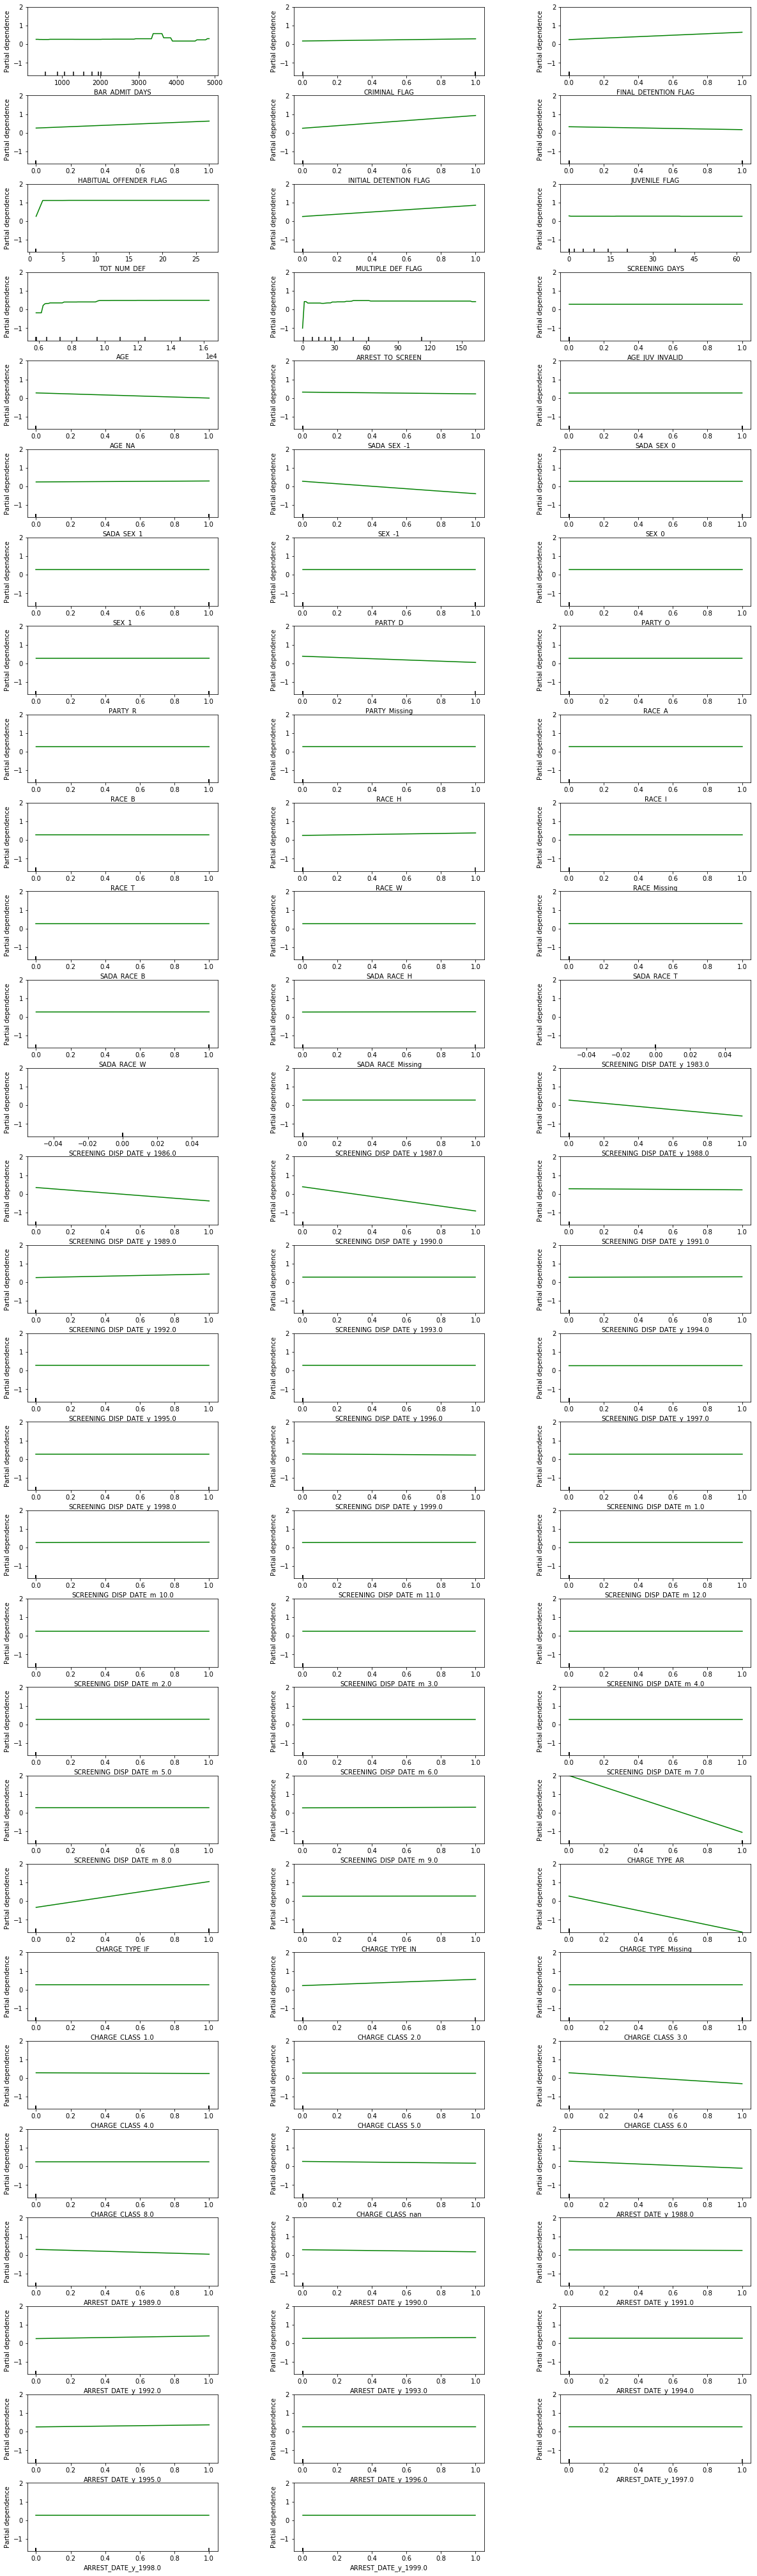

In [78]:
plot_partial_dependence(predicted_prosecutor, X_train, \
                        np.arange(0, len(X_train.columns)), feature_names = list(X_train.columns), label=1)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 100.5)

In [ ]:
#My old code was plotting the first 5 variables and assigning different names to them.
#Charge_TYPE_AR means it's less likely that charges will be accepted.
#Charge_type_IN makes it more likely that charges will be accepted.
#Arrest to screen, if it's more than a day, makes it more likely that charges will be accepted.
#Charges are less likely to be accepted if the disp date is 1989, 1990, 1988. The other years look positive or flat.
#Age makes it more likely that charges will be accepted, but it has a sharp increase at first and then slows
#(Age is in days, partial dependence plateaus at 7,000 days, which is around 19 years old.)

### Logistic Regression Version

In [140]:
X_train_lr = preprocessing.scale(X_train)

In [142]:
predicted_prosecutor_lr = LogisticRegression()

In [143]:
predicted_prosecutor_lr.fit(X_train_lr, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [144]:
X_val_lr = preprocessing.scale(X_val)

In [145]:
predictions_lr = predicted_prosecutor_lr.predict(X_val_lr)
predicted_probability_lr = predicted_prosecutor_lr.predict_proba(X_val_lr)

In [146]:
lr_cm = sklearn.metrics.confusion_matrix(y_val,predictions_lr)
lr_cm

array([[18745,  1310],
       [ 3118, 13744]])

In [100]:
gbt_cm #for comparison

array([[18919,  1136],
       [ 2987, 13875]])

In [147]:
#Accuracy
print ('Accuracy: ', sklearn.metrics.accuracy_score(y_val, predictions_lr))

#Precision
print ('Precision: ', sklearn.metrics.precision_score(y_val, predictions_lr))

#Recall
print ('Recall: ', sklearn.metrics.recall_score(y_val, predictions_lr))

#F-score
print ('F-score: ', sklearn.metrics.f1_score(y_val, predictions_lr))

#Recall is close, precision isn't quite as good


Accuracy:  0.880055259095
Precision:  0.912979938887
Recall:  0.815087178271
F-score:  0.861260809625


In [106]:
#Accuracy
print ('Accuracy: ', sklearn.metrics.accuracy_score(y_val, predictions))

#Precision
print ('Precision: ', sklearn.metrics.precision_score(y_val, predictions))

#Recall
print ('Recall: ', sklearn.metrics.recall_score(y_val, predictions))

#F-score
print ('F-score: ', sklearn.metrics.f1_score(y_val, predictions))

Accuracy:  0.888317035512
Precision:  0.924322163747
Recall:  0.822856126201
F-score:  0.870642863866


In [148]:
#Coefficients

coefficients = pd.DataFrame(list(zip(np.ravel(predicted_prosecutor_lr.coef_), X_train.columns)))

coefficients = coefficients.rename(columns = {0:'coefficient', 1:'feature'})


In [134]:
imp_features = ['CHARGE_TYPE_AR', 'ARREST_TO_SCREEN', 'SCREENING_DISP_DATE_y_1989.0', 'AGE', 'CHARGE_TYPE_IF']


In [149]:
coefficients.loc[coefficients.feature.isin(imp_features), ]


,coefficient,feature
9,0.055807,AGE
10,-0.052553,ARREST_TO_SCREEN
39,-0.312261,SCREENING_DISP_DATE_y_1989.0
62,-1.142138,CHARGE_TYPE_AR
63,1.125550,CHARGE_TYPE_IF


In [ ]:
# The LR agrees directionally on all but ARREST_TO_SCREEN

In [152]:
coefficients['coefficient_abs_val'] = abs(coefficients['coefficient'])

In [154]:
coefficients.sort(columns = 'coefficient_abs_val', ascending=False)
#this might be easier to arrive at a causal story for

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,coefficient,feature,coefficient_abs_val
62,-1.142138,CHARGE_TYPE_AR,1.142138
63,1.125550,CHARGE_TYPE_IF,1.125550
13,-0.638365,SADA_SEX_-1,0.638365
5,-0.533778,JUVENILE_FLAG,0.533778
40,-0.436447,SCREENING_DISP_DATE_y_1990.0,0.436447
3,0.429835,HABITUAL_OFFENDER_FLAG,0.429835
4,0.317616,INITIAL_DETENTION_FLAG,0.317616
39,-0.312261,SCREENING_DISP_DATE_y_1989.0,0.312261
2,0.267158,FINAL_DETENTION_FLAG,0.267158
16,-0.235054,SEX_-1,0.235054


### Error Analysis

In [ ]:
#Haven't yet adapted code below to the predicted prosecutor model

In [9]:
#preds_to_analyze = models_predict_val['Model59']

preds_to_analyze = best_model_predictions

np.save('pred_val_5yr_gbt_optimal.npy', preds_to_analyze)

In [10]:
probs_to_analyze = best_model_predicted_prob

In [11]:
val['AGE'] = val['AGE']/365

In [9]:
numeric = ['NEXT_ARREST_TIME','ARREST_DATE_y', 'BAR_ADMIT_DAYS', 'CRIMINAL_FLAG','FINAL_DETENTION_FLAG',\
           'HABITUAL_OFFENDER_FLAG','INITIAL_DETENTION_FLAG','JUVENILE_FLAG','TOT_NUM_DEF','MULTIPLE_DEF_FLAG',\
           'SCREENING_DAYS','ARREST_DATE_y','AGE', 'AGE_JUV_INVALID', 'AGE_NA', 'ARREST_TO_SCREEN']

numeric_exc_binary = ['NEXT_ARREST_TIME','ARREST_DATE_y','SCREENING_DAYS','SCREENING_DISP_DATE_y',\
                      'SCREENING_DISP_DATE_m','AGE']

categorical =['CHARGE_TYPE',\
       'PARTY', 'RACE', 'SADA_RACE','SEX','SADA_SEX']

categorical_and_binary = ['CHARGE_CLASS', 'CHARGE_TYPE',\
       'PARTY', 'RACE', 'SADA_RACE','SEX','SADA_SEX', 'CRIMINAL_FLAG',\
        'JUVENILE_FLAG', 'MULTIPLE_DEF_FLAG', 'AGE_JUV_INVALID', 'AGE_NA']

In [10]:
val_error = ea.Error_Analysis('5_yr_gbt_optimal', 'data_processing/output/data_val.csv', \
                              'pred_val_5yr_gbt_optimal.npy')

val_error.create_err_analysis_df(5)

val_error.divide_preds()

10994
10994


In [ ]:
data = val_error.err_analysis

data['NEXT_ARREST_YEAR'] = data['NEXT_ARREST_TIME'].astype(float)/365

data['NEXT_ARREST_YEAR'] = data['NEXT_ARREST_YEAR'].astype(int)

In [ ]:
#Recall by next_arrest_year
pd.pivot_table(data[data['True_Y'] ==1], values = 'Pred_Y', index='NEXT_ARREST_YEAR').plot(kind="bar")

In [ ]:
#Percent Predicted Positive Class with a True_Y = 0 by next_arrest_year
pd.pivot_table(data[data['True_Y'] ==0], values = 'Pred_Y', index='NEXT_ARREST_YEAR').plot(kind="bar")

#The model frequently misclassifies people who will be rearrested far in the future as rearrested within 5 years
#however, it rarely (20% of the time) misclassifies people who will never be rearrested

In [ ]:
#Precision by next_arrest_year
pd.pivot_table(data[data['Pred_Y'] ==1], values = 'True_Y', index='NEXT_ARREST_YEAR').plot(kind="bar")

In [ ]:
#Precision by next arrest year
data['COUNT'] = 1
precision_by_arrest_year = pd.pivot_table(data[data['Pred_Y'] ==1], values = ['COUNT', 'CORRECT'], index='NEXT_ARREST_YEAR', aggfunc=sum)

In [ ]:
precision_by_arrest_year['Percent'] = precision_by_arrest_year['CORRECT']/precision_by_arrest_year['COUNT']

In [ ]:
precision_by_arrest_year

#what does this mean? there are 3,514 records predicted as rearrested with a next_arrest_year of 0
#next_arrest_year of 0 means either not rearrested or rearrested within less than a year

#### The two important boxplots

In [ ]:
has_rearrest_incorrect_pred = val_error.wrong_pred[val_error.wrong_pred['True_Y'] == 1]

has_rearrest_correct_pred = val_error.right_pred[val_error.right_pred['True_Y'] == 1]

has_rearrest_incorrect_pred['NEXT_ARREST_TIME'] = has_rearrest_incorrect_pred['NEXT_ARREST_TIME']/365

has_rearrest_incorrect_pred=has_rearrest_incorrect_pred.rename(columns = {'NEXT_ARREST_TIME':'Next Arrest Time'})

has_rearrest_correct_pred['NEXT_ARREST_TIME'] = has_rearrest_correct_pred['NEXT_ARREST_TIME']/365

has_rearrest_correct_pred=has_rearrest_correct_pred.rename(columns = {'NEXT_ARREST_TIME':'Next Arrest Time'})

In [ ]:
plt.figure(1)
plt.gcf().set_size_inches(8,4) 

rows = 1

ax1 = plt.subplot(rows,2,1)
ax1.set_title('Incorrect Prediction', fontsize=15)
ax1.set_ylabel('Years to Rearrest', fontsize = 15)
ax1.set_yticklabels(labels = [-1,0,1,2,3,4,5], fontdict = {'fontsize': 15})
has_rearrest_incorrect_pred['Next Arrest Time'].plot.box()
ax1.set_xticklabels(labels = [''])
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

ax2 = plt.subplot(rows,2,2, sharey=ax1)
ax2.set_title('Correct Prediction', fontsize=15)
has_rearrest_correct_pred['Next Arrest Time'].plot.box()
ax2.set_xticklabels(labels=[''])
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
plt.savefig('next_arrest_time' + '_boxplots.png')

In [ ]:
data[numeric].corrwith(data['NEXT_ARREST_TIME'])

In [ ]:
correlations = data[data['True_Y'] ==1][numeric].corrwith(data[data['True_Y'] ==1]['NEXT_ARREST_TIME'])

correlations.sort_values()

In [ ]:
#pretty highly correlated with criminal flag
#also negatively correlated with juvenile flag
#also slightly correlated with age

In [ ]:
#Correlation between criminal flag and time to rearrest

x = np.array(data[data['True_Y'] ==1]['CRIMINAL_FLAG'])
y = np.array(data[data['True_Y'] ==1]['NEXT_ARREST_TIME'])

pearsonr(x,y)

In [ ]:
data['Probability'] = best_model_predicted_prob[:,1]

In [ ]:
#Correlation between next arrest time and probability of rearrest

x = np.array(data[data['True_Y'] ==1]['Probability'])
y = np.array(data[data['True_Y'] ==1]['NEXT_ARREST_TIME'])

pearsonr(x,y)

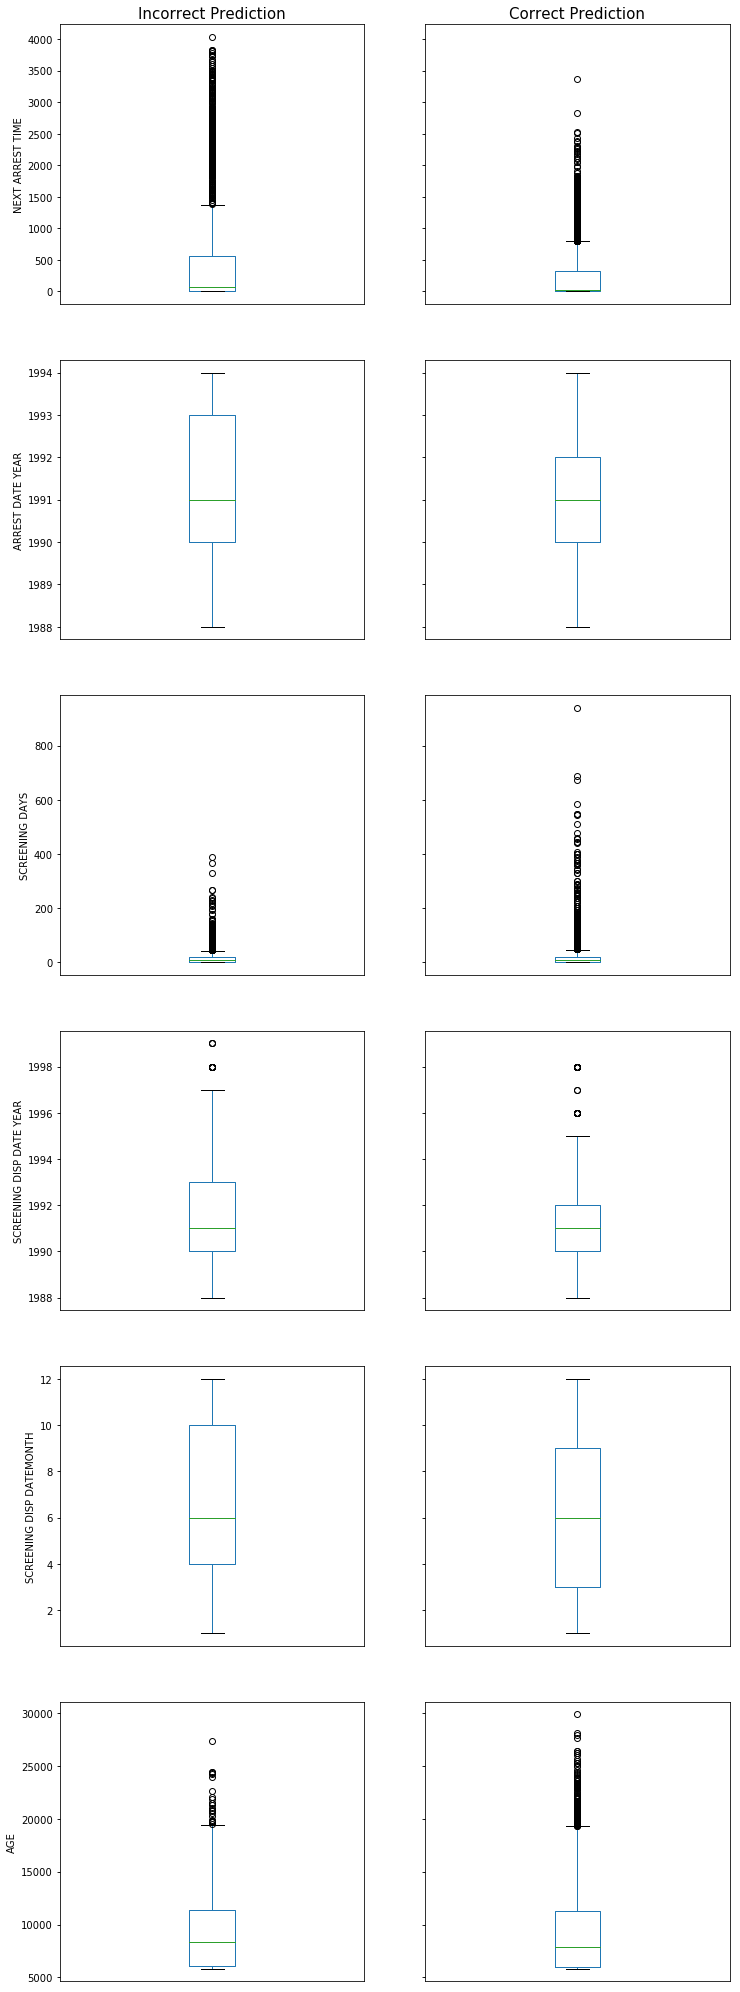

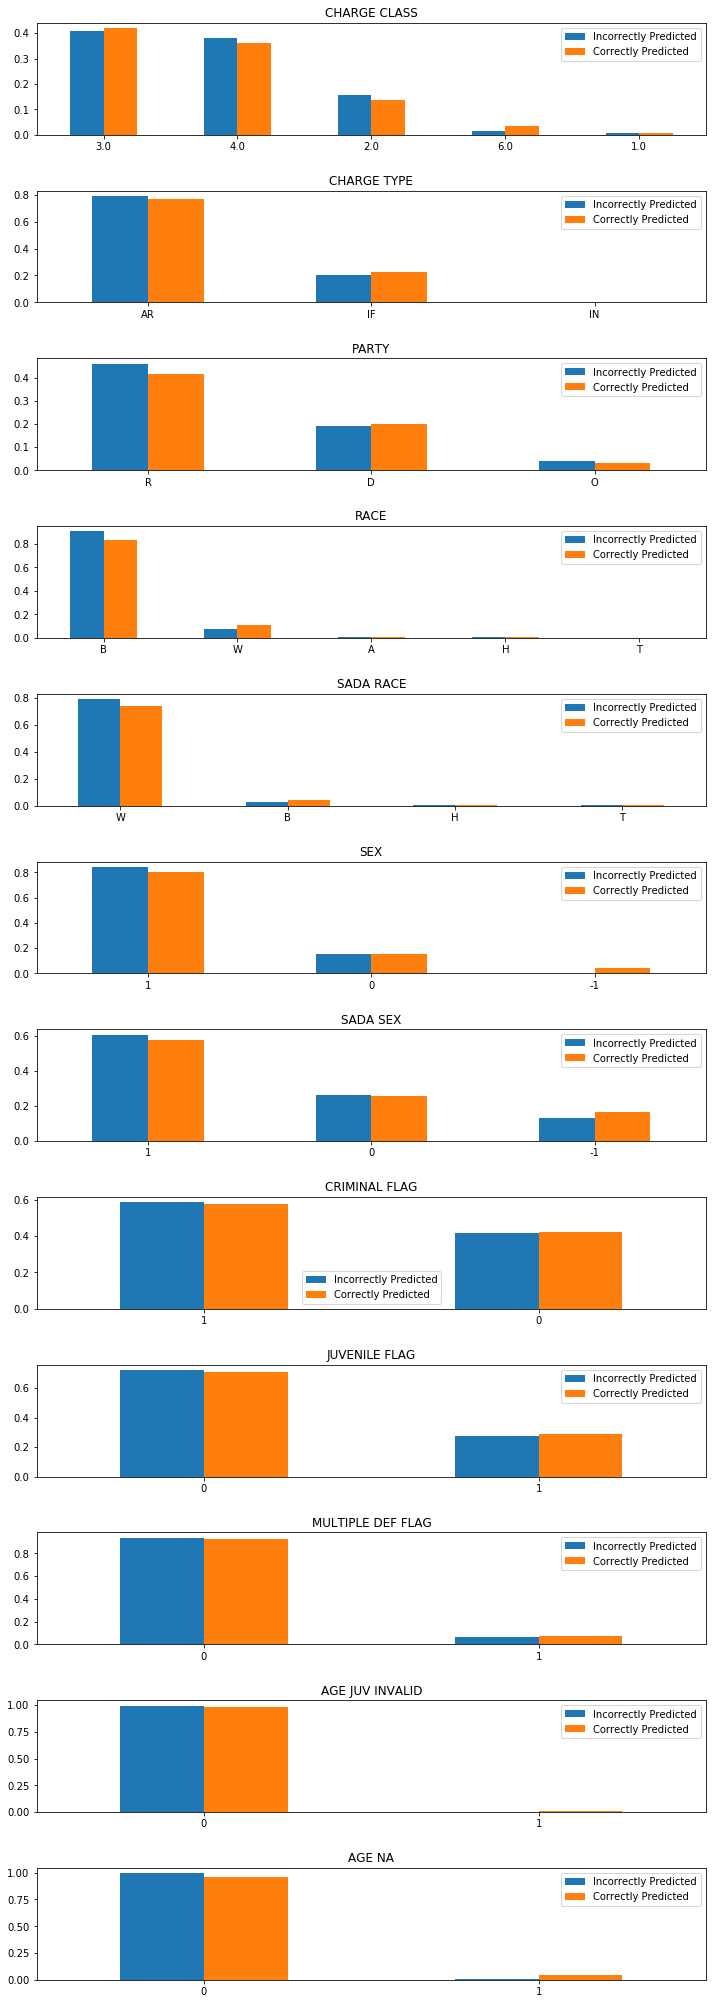

In [44]:
val_error.all_error_analysis(5, numeric_exc_binary, numeric, categorical_and_binary)